# FEgrow: An Open-Source Molecular Builder and Free Energy Preparation Workflow

**Authors: Mateusz K Bieniek, Ben Cree, Rachael Pirie, Joshua T. Horton, Natalie J. Tatum, Daniel J. Cole**

## Overview

Building and scoring molecules can be further streamlined by employing our established protocol. Here we show how to quickly build a library and score the entire library. 

In [1]:
import pandas as pd
import prody
from rdkit import Chem

import fegrow
from fegrow import ChemSpace

from fegrow.testing import core_5R83_path, rec_5R83_path, data_5R83_path

/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tmp/ipykernel_2905623/1015952767.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


# Prepare the ligand template

In [2]:
#!grep "XEY" 7l10.pdb > in.pdb
!obabel -ipdb lig-79.pdb -O in-H.sdf -p 7

1 molecule converted


In [3]:
#scaffold = Chem.SDMolSupplier(core_5R83_path)[0]
scaffold = Chem.SDMolSupplier('in-H.sdf')[0]

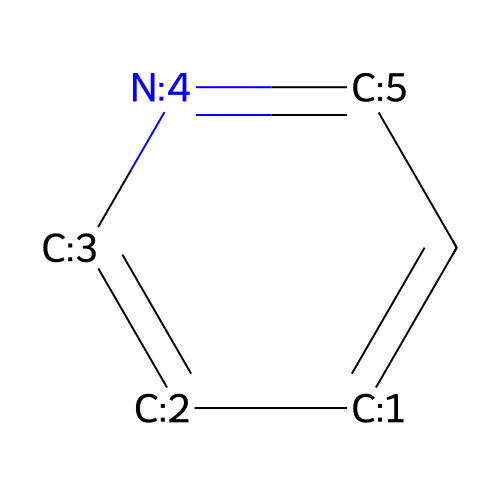

In [4]:
toview = fegrow.RMol(scaffold)
toview.rep2D(idx=True, size=(500, 500))

In [6]:
with open('smiles-test-MERS.txt') as f:
    mols = f.read().splitlines()

In [7]:
mols[0]

'O=C1c2ccc(Cl)cc2[C@@]2(CN1Cc1nnco1)C(=O)N(c1cncc3ccccc13)C[C@@H]2CNc1ncncn1'

In [8]:
#mols = ['C1(OCCC)=CC=CN=C1',
#        'CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2CNc2ccncn2)c2cc(Cl)ccc2C1=O',
#        'CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2CNc2cnn(C)c2)c2cc(Cl)ccc2C1=O',
#        'Cc1cnc(CN2C[C@@]3(C(=O)N(c4cncc5ccccc45)C[C@@H]3C)c3cc(F)ccc3C2=O)cn1',
#        'CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2COC(C)C)c2cc(Cl)ccc2C1=O',
#        'C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(Cc1nccn1C)C(=O)c1ccc(F)cc12'
#       ]

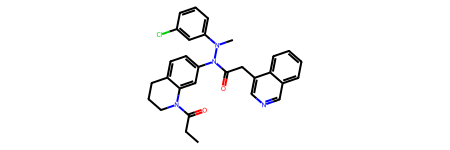

In [10]:
Chem.MolFromSmiles(mols[20])

In [11]:
pattern = scaffold

for i in range(len(mols)):
    mol = Chem.MolFromSmiles(mols[i])
    if mol.HasSubstructMatch(pattern) == False:
        print(i, mols[i])

78 COC(=O)N[C@H](C(=O)N1C[C@H](C(F)(F)F)C[C@H]1C(=O)N[C@H](C[NH3+])C[C@@H]1CCNC1=O)C(C)(C)C


As we are using already prepared Smiles that have the scaffold as a substructure, it is not needed to set any growing vector. 

In [12]:
from dask.distributed import LocalCluster
lc = LocalCluster(processes=True, n_workers=None, threads_per_worker=1)

/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46155 instead
  warnings.warn(
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '

In [13]:
# create the chemical space
cs = ChemSpace(dask_cluster=lc)
cs

Failed to patch pandas - unable to change molecule rendering


Dask can be watched on http://127.0.0.1:46155/status


,Smiles,score,h,Training,Success,enamine_searched,enamine_id,2D


In [14]:
#cs._dask_cluster

In [15]:
# we're not growing the scaffold, we're superimposing bigger molecules on it
cs.add_scaffold(scaffold)

/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/fegrow/package.py:799: UserWarning: The template does not have an attachement (Atoms with index 0, or in case of Smiles the * character. )
  warnings.warn("The template does not have an attachement (Atoms with index 0, "


In [16]:
# get the protein-ligand complex structure
#!wget -nc https://files.rcsb.org/download/3vf6.pdb

# load the complex with the ligand
sys = prody.parsePDB('complex-MERS.pdb')

# remove any unwanted molecules
rec = sys.select('not (nucleic or hetatm or water)')

# save the processed protein
prody.writePDB('rec.pdb', rec)

# fix the receptor file (missing residues, protonation, etc)
fegrow.fix_receptor("rec.pdb", "rec_final.pdb")

# load back into prody
#rec_final = prody.parsePDB("rec_final.pdb")
#rec_final = prody.parsePDB("out.pdb")

# fix the receptor file (missing residues, protonation, etc)
##fegrow.fix_receptor("7t79-H-prep.pdb", "rec_final.pdb")

# load back into prody
##rec_final = prody.parsePDB("rec_final.pdb")

#!grep "ATOM" ../structures/7t79-H.pdb > rec_final.pdb
#cs.add_protein(rec_5R83_path)
cs.add_protein('rec_final.pdb')

@> 9116 atoms and 1 coordinate set(s) were parsed in 0.10s.


In [17]:
smiles = []
list_of_fails = [20, 31, 73, 74, 77]

for i in list_of_fails:
    smiles.append(mols[i])

In [18]:
# load 50k Smiles
#smiles = pd.read_csv('csv/arthor-hits-2024Mar26-0918.csv',
#                     names=["Smiles", "??", "db"],
#                     index_col=0).Smiles

#smiles = pd.read_csv('smiles.csv').Smiles.to_list()


# take all 20000
#smiles = smiles.apply(lambda r: r.split()[0])
#smiles = mols[0:]

# here we add Smiles which should already have been matched
# to the scaffold (rdkit Mol.HasSubstructureMatch)
#cs.add_smiles(smiles.to_list(), protonate=True)
cs.add_smiles(smiles, protonate=True)
cs

Failed to patch pandas - unable to change molecule rendering


,Smiles,score,h,Training,Success,enamine_searched,enamine_id,2D
0,C(C(C(=O)N1C(C(C(c2c(c(c(N(C(=O)C(c3c(nc(c4c(c...,<NA>,<NA>,False,NaN,False,NaN,<rdkit.Chem.rdchem.Mol object at 0x7f67204157e0>
1,O=C1c2c(c(c(Cl)c(c2[C@@]2(C(N1C(c1nnc(o1)[H])(...,<NA>,<NA>,False,NaN,False,NaN,<rdkit.Chem.rdchem.Mol object at 0x7f6720416a40>
2,C([C@]1(C(N(c2c(nc(c3c(c(c(c(c23)[H])[H])[H])[...,<NA>,<NA>,False,NaN,False,NaN,<rdkit.Chem.rdchem.Mol object at 0x7f67837d5fc0>
3,C([C@]1(C(N(c2c(nc(c3c(c(c(c(c23)[H])[H])[H])[...,<NA>,<NA>,False,NaN,False,NaN,<rdkit.Chem.rdchem.Mol object at 0x7f67837d4580>
4,C(C(C([H])([H])[H])(C#N)c1c(c(c(N(C(c2c(c(c(c(...,<NA>,<NA>,False,NaN,False,NaN,<rdkit.Chem.rdchem.Mol object at 0x7f67206b4dd0>


In [19]:
cs.evaluate(num_conf=500, gnina_gpu=True, penalty=0.0, al_ignore_penalty=False)

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: 

Generated 95 conformers. 
Removed 76 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/19 [00:00<?, ?it/s][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:   5%|█▏                    | 1/19 [00:02<00:46,  2.59s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  21%|████▋                 | 4/19 [00:11<00:47,  3.14s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: User

Generated 67 conformers. 
Removed 56 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


[W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  58%|████████████▏        | 11/19 [00:28<00:16,  2.05s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer: 100%|█████████████████████| 11/11 [00:38<00:00,  3.50s/it]
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warning

Generated 417 conformers. 
Removed 367 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/50 [00:00<?, ?it/s][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  52%|██████████▉          | 26/50 [01:42<01:32,  3.85s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")
Optimising conformer:  56%|███████████▊         | 28/50 [01:45<00:59,  2.69s/it]

Generated 461 conformers. 
Removed 458 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  58%|████████████▏        | 29/50 [01:47<00:55,  2.64s/it][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  84%|█████████████████▋   | 42/50 [03:19<00:51,  6.47s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")
Optimising conformer:  86%|██████████████████   | 43/50 [03:23<00:41,  5.94s/it]

Generated 297 conformers. 
Removed 261 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/36 [00:00<?, ?it/s][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer: 100%|█████████████████████| 36/36 [03:06<00:00,  5.17s/it]


,Smiles,Mol,score,h,Training,Success,enamine_searched,enamine_id
0,C(C(C(=O)N1C(C(C(c2c(c(c(N(C(=O)C(c3c(nc(c4c(c...,<fegrow.package.RMol object at 0x7f6780565490>,6.606,<NA>,True,True,False,NaN
1,O=C1c2c(c(c(Cl)c(c2[C@@]2(C(N1C(c1nnc(o1)[H])(...,<fegrow.package.RMol object at 0x7f678043f3d0>,6.96,<NA>,True,True,False,NaN
2,C([C@]1(C(N(c2c(nc(c3c(c(c(c(c23)[H])[H])[H])[...,<fegrow.package.RMol object at 0x7f67801c0180>,6.578,<NA>,True,True,False,NaN
3,C([C@]1(C(N(c2c(nc(c3c(c(c(c(c23)[H])[H])[H])[...,<fegrow.package.RMol object at 0x7f678028c7c0>,6.525,<NA>,True,True,False,NaN
4,C(C(C([H])([H])[H])(C#N)c1c(c(c(N(C(c2c(c(c(c(...,<fegrow.package.RMol object at 0x7f678026ef20>,6.667,<NA>,True,True,False,NaN


In [20]:
cs.df

,Smiles,Mol,score,h,Training,Success,enamine_searched,enamine_id
0,C(C(C(=O)N1C(C(C(c2c(c(c(N(C(=O)C(c3c(nc(c4c(c...,<fegrow.package.RMol object at 0x7f6780565490>,6.606,<NA>,True,True,False,NaN
1,O=C1c2c(c(c(Cl)c(c2[C@@]2(C(N1C(c1nnc(o1)[H])(...,<fegrow.package.RMol object at 0x7f678043f3d0>,6.96,<NA>,True,True,False,NaN
2,C([C@]1(C(N(c2c(nc(c3c(c(c(c(c23)[H])[H])[H])[...,<fegrow.package.RMol object at 0x7f67801c0180>,6.578,<NA>,True,True,False,NaN
3,C([C@]1(C(N(c2c(nc(c3c(c(c(c(c23)[H])[H])[H])[...,<fegrow.package.RMol object at 0x7f678028c7c0>,6.525,<NA>,True,True,False,NaN
4,C(C(C([H])([H])[H])(C#N)c1c(c(c(N(C(c2c(c(c(c(...,<fegrow.package.RMol object at 0x7f678026ef20>,6.667,<NA>,True,True,False,NaN


In [21]:
cs.to_sdf("cs_optimised_molecules.sdf")

In [22]:
for i in range (len(cs)):
    try:
        cs[i].to_file("best_conformers_{0}.pdb".format(list_of_fails[i]))
    except AttributeError:
        print("No conformer for molecule", i)

In [23]:
cs.df.to_csv('MERS-out.csv', index=True)